In [1]:

import json
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    pipeline
)

DATA_PATH = "/kaggle/input/threeanswers/entries_with_all_3_answers.json"   

with open(DATA_PATH, "r", encoding="utf-8") as f:
    items = json.load(f)   

ids, contexts, questions, answers = [], [], [], []

auto_id = 0
for item in items:
    ctx = item["context"]
    for qa in item["qas"]:
        qid = qa.get("id", str(auto_id)); auto_id += 1
        q = qa["question"]
        # keep answers as lists to match SQuAD format
        for ans in qa["answers"]:
            ids.append(qid)
            contexts.append(ctx)
            questions.append(q)
            answers.append({
                "text": [ans["text"]],
                "answer_start": [ans["answer_start"]],
            })

dataset = Dataset.from_dict({
    "id": ids,
    "context": contexts,
    "question": questions,
    "answers": answers
})
print("Flat dataset:", dataset)

2025-09-28 06:06:54.750868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759039614.952472      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759039615.010535      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Flat dataset: Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 5861
})


In [2]:
# Cell 2
from transformers import AutoTokenizer


# 1. Split the Full Dataset
dataset_split = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]  # This is our 10% evaluation set

print(f"Full dataset split into {len(train_dataset)} training examples and {len(eval_dataset)} evaluation examples.")

# 2. Load the Tokenizer
model_ckpt = "deepset/xlm-roberta-large-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# 3. Define the Feature Preparation Function
def prepare_features(examples, tokenizer):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    sample_mapping = tokenized.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized["offset_mapping"]

    tokenized["start_positions"] = []
    tokenized["end_positions"] = []
    
    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id) if tokenizer.cls_token_id in input_ids else 0
        
        sequence_ids = tokenized.sequence_ids(i)
        sample_index = sample_mapping[i]
        ans = examples["answers"][sample_index]
        
        if len(ans['text']) == 0:
            tokenized["start_positions"].append(cls_index)
            tokenized["end_positions"].append(cls_index)
        else:
            start_char = ans["answer_start"][0]
            end_char = start_char + len(ans["text"][0])
            
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1
            
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1
                
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized["start_positions"].append(cls_index)
                tokenized["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized["start_positions"].append(token_start_index - 1)
                
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized["end_positions"].append(token_end_index + 1)
                
    return tokenized

# 4. Create the Final Tokenized Evaluation Datasets
print("\nTokenizing the evaluation dataset...")



tokenized_train_ds = train_dataset.map(prepare_features, batched=True, remove_columns=train_dataset.column_names, fn_kwargs={'tokenizer': tokenizer})
tokenized_eval_ds = eval_dataset.map(prepare_features, batched=True, remove_columns=eval_dataset.column_names, fn_kwargs={'tokenizer': tokenizer})

print("\n✅ Evaluation datasets are ready.")
print(f" - `eval_dataset`: Contains {len(eval_dataset)} original text examples.")
print(f" - `tokenized_eval_ds`: For the Trainer to calculate loss.")
print(f" - `tokenized_eval_ds_for_metric`: For calculating the final EM & F1 scores.")

Full dataset split into 5274 training examples and 587 evaluation examples.


tokenizer_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]


Tokenizing the evaluation dataset...


Map:   0%|          | 0/5274 [00:00<?, ? examples/s]

Map:   0%|          | 0/587 [00:00<?, ? examples/s]


✅ Evaluation datasets are ready.
 - `eval_dataset`: Contains 587 original text examples.
 - `tokenized_eval_ds`: For the Trainer to calculate loss.
 - `tokenized_eval_ds_for_metric`: For calculating the final EM & F1 scores.


In [4]:
pip install --upgrade transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 113.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
Note: you may need to restart the kernel to use updated packages.


In [3]:

!pip install evaluate
import evaluate

from transformers import TrainingArguments, Trainer, AutoModelForQuestionAnswering, AutoConfig, EarlyStoppingCallback



config = AutoConfig.from_pretrained(model_ckpt)

# Increase dropout probabilities for regularization
config.hidden_dropout_prob = 0.2          
config.attention_probs_dropout_prob = 0.2 

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt, config=config)


training_args = TrainingArguments(
    output_dir="./results",

   
    learning_rate=2e-5,
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    fp16=True,
    weight_decay=0.01, 
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    save_total_limit=2,

    # Best Model Selection
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none",
)

early_stopping = EarlyStoppingCallback(early_stopping_patience=3)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1]:
!rm -rf /kaggle/working/results/

In [4]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,      
    eval_dataset=tokenized_eval_ds,      
    callbacks=[early_stopping]
)


print("Starting fine-tuning...")
trainer.train()


final_model_path = "./final-xlm-roberta-event-model"
trainer.save_model(final_model_path)

print(f"Training complete. Best model saved to {final_model_path}")

Starting fine-tuning...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.436200,1.352213
2,1.316100,1.339201
3,1.110100,1.222579
4,0.974500,1.291436
5,0.851100,1.408744
6,0.701700,1.366726


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Training complete. Best model saved to ./final-xlm-roberta-event-model


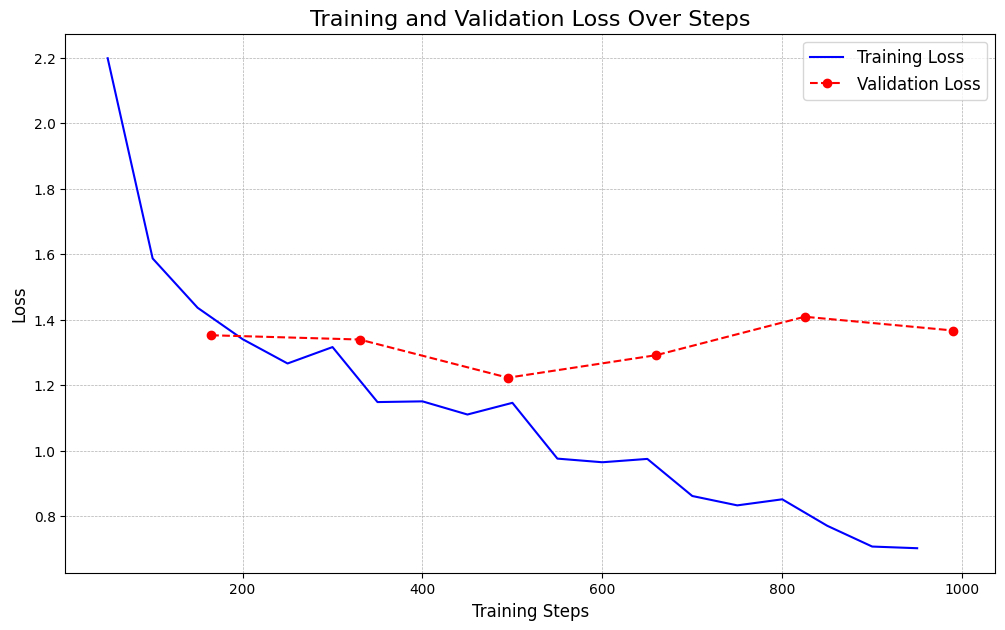

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


training_logs = []
validation_logs = []

for log in trainer.state.log_history:
  
    if 'loss' in log:
        training_logs.append(log)
    elif 'eval_loss' in log:
        validation_logs.append(log)


train_df = pd.DataFrame(training_logs)
eval_df = pd.DataFrame(validation_logs)


if not training_logs or 'loss' not in training_logs[-1]:
     
     pass


plt.figure(figsize=(12, 7))

plt.plot(train_df['step'], train_df['loss'], label='Training Loss', color='b')


plt.plot(eval_df['step'], eval_df['eval_loss'], label='Validation Loss', marker='o', linestyle='--', color='r')


plt.title("Training and Validation Loss Over Steps", fontsize=16)
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.show()

In [1]:
!zip -r final-xlm-roberta-event-model.zip final-xlm-roberta-event-model/*


updating: final-xlm-roberta-event-model/config.json (deflated 49%)
updating: final-xlm-roberta-event-model/model.safetensors^C



zip error: Interrupted (aborting)
